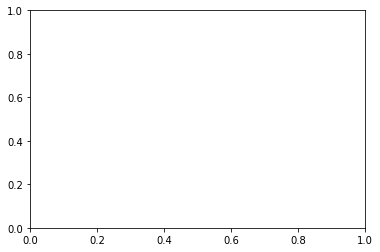

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot()

In [2]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

from os import listdir
from os.path import isfile, join

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


In [3]:
torch.cuda.set_device(0)

import crnn.utils as crnn_utils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

alphabet = '0123456789abcdefghijklmnopqrstuvwxyz.-%$'
converter = crnn_utils.strLabelConverter(alphabet)

In [4]:
demonet = 'vgg16' # Network to use [vgg16 res101]
dataset = 'coco_text' # Trained dataset [pascal_voc pascal_voc_0712]

In [5]:
modelPath = '../output/vgg16/coco_text_2018_trainval/default/vgg16_faster_rcnn_iter_200000.pth'
if True:
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals
    saved_model = modelPath # 4-class{back, tit, xla, yla}
    CLASSES = ('__background__', 'text')
    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(len(CLASSES), tag='default', anchor_scales=[2, 4, 8, 16,32], 
                            anchor_ratios=(0.5,1,2), test_mode=True)

number of anchors =  15
/home/xliu/coco_text/tools/../lib/nets/network.py


In [6]:
directLoad = False
directLoad = True

if directLoad:
    state_dict = torch.load(modelPath)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items(): 
        name = k.replace('module.','') #[7:] # remove `module.`
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)

In [13]:
def vis_detections1(ax, im, class_name, dets, ttt, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        #print(bbox, class_name)

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        if (class_name=="text"):
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s}'.format(ttt[i]),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')
        else:
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s}'.format(class_name),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

In [14]:
import imutils

In [15]:
def demo1(net, image_name, CONF_THRESH = 0.7, angle = 0, NMS_THRESH = 0.2):
    """Detect object classes in an image using pre-computed object proposals."""

    im_file = image_name
    im = cv2.imread(im_file)
    im = imutils.rotate(im, angle)

    print('Demo for {}'.format(im_file))

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes, text = im_detect(net, im)
    
    batch_size=300
    preds = Variable(torch.from_numpy(text))

    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    _, preds = preds.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    
    for cls_ind, cls in enumerate(CLASSES[1:]):
    #for cls_ind, cls in enumerate(CLASSES[0:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        #print(keep)
        ttt = [sim_preds[i] for i in keep.numpy()]
        vis_detections1(ax, im, cls, dets, ttt, thresh=CONF_THRESH)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    return scores, boxes, text

In [16]:
for cls_ind, cls in enumerate(CLASSES[0:]):
    print(cls_ind, cls)

0 __background__
1 text


In [11]:
net = net.cuda()
net.eval()
#cfg.TEST.MODE='top'

vgg16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, padd

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for ../data/VOCdevkit2018/coco_text2018/JPEGImages/87/jogging_23_47.jpg


/home/xliu/coco_text/tools/../lib/nets/network.py:539: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self._image = Variable(torch.from_numpy(image.transpose([0,3,1,2])).cuda(), volatile=mode == 'TEST')
/home/xliu/coco_text/tools/../lib/nets/network.py:359: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/xliu/coco_text/tools/../lib/nets/network.py:396: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


[[[  4.35026741  -2.72219157  -5.63029099 ...,  -8.02208996  -8.31716442
    -7.83665657]
  [  2.0840385   -5.9505558   -0.25242648 ...,  -5.46497059  -4.26614952
    -7.48312426]
  [  2.44137955  -7.72172308  -2.78415489 ...,  -3.85900736  -5.2814703
   -10.04553127]
  ..., 
  [  2.76733446  -2.15198612  -3.20686674 ...,  -5.89764881  -4.34919643
    -5.12778378]
  [  1.3356874   -5.64955759  -1.48569095 ...,  -6.03321743  -3.23834062
    -6.24660254]
  [  3.98082733  -5.29549265  -5.33597231 ...,  -5.82808685  -6.32044697
    -6.80030775]]

 [[  3.58116961  -0.81452578  -5.2907958  ...,  -8.53108788  -7.26998568
    -8.4300375 ]
  [ 12.00996208  -5.32366467  -2.69738722 ...,  -9.30571365  -9.28008556
   -13.53648758]
  [  4.61505651  -7.88018227  -3.6779058  ...,  -5.87686253  -7.76480246
   -12.65213203]
  ..., 
  [  3.2982986   -2.77899432  -3.88880396 ...,  -7.50662041  -6.65308285
    -7.37824249]
  [  4.74820805  -5.19659424  -3.04936051 ...,  -8.22293186  -7.12017632
    -9.737

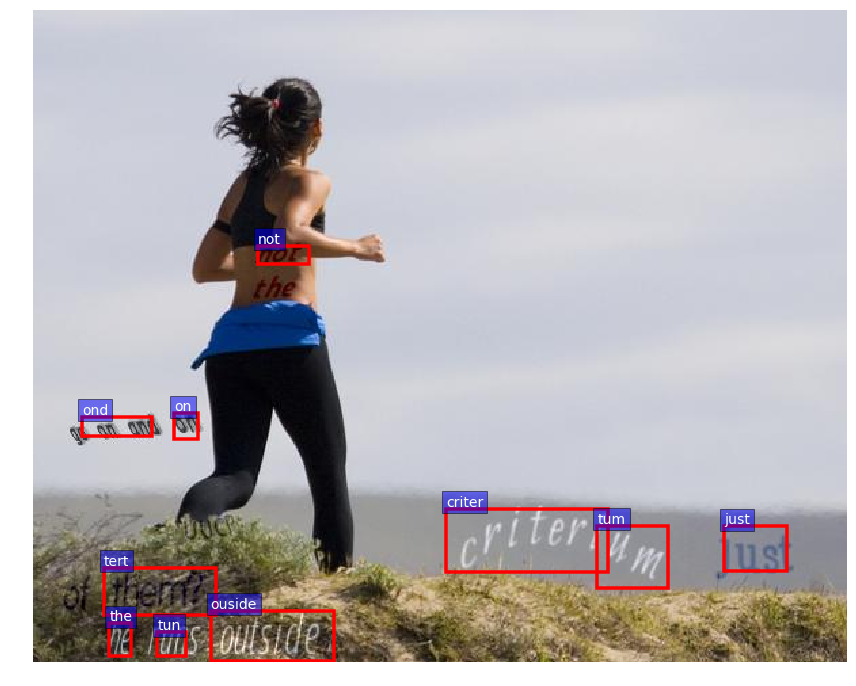

In [22]:
mypath = '../data/VOCdevkit2018/coco_text2018/JPEGImages/87/'
im_names = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
#im_names = [mypath+ind+'.jpg' for ind in bar_list]
for im_name in im_names[:1]:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    #print('Demo for data/demo/{}'.format(im_name))
    with torch.no_grad():
        try:
            s,b,t = demo1(net, im_name, CONF_THRESH = 0.8, angle=0)
            plt.show()
        except:
            print("Type Unsupported")
    #plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_101.jpg


/home/xliu/coco_text/tools/../lib/nets/network.py:539: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self._image = Variable(torch.from_numpy(image.transpose([0,3,1,2])).cuda(), volatile=mode == 'TEST')
/home/xliu/coco_text/tools/../lib/nets/network.py:359: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/xliu/coco_text/tools/../lib/nets/network.py:396: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


[[[  2.03038096  -2.7845428   -0.11137971 ...,  -3.82910776  -2.34033275
    -5.852458  ]
  [  1.49937701  -2.85906577  -2.16171718 ...,  -4.67908907  -4.58016872
    -4.79124403]
  [  1.45297503  -3.37151027  -1.59697628 ...,  -5.80309153  -5.09883118
    -6.51915312]
  ..., 
  [  2.20390749  -4.08262968  -1.11914861 ...,  -4.16677284  -2.78561163
    -6.74352694]
  [  3.74644065  -4.18665075  -0.79051292 ...,  -4.3123064   -2.64097428
    -7.57759094]
  [  2.72225904  -4.04363728  -1.10834444 ...,  -4.53448343  -3.00758767
    -6.89236784]]

 [[  0.75839263  -0.29044542  -1.10366106 ...,  -5.00437498  -5.12884808
    -6.01973009]
  [  2.3623724   -2.05302119  -2.98658586 ...,  -6.56377411  -7.78530216
    -7.41853905]
  [  2.14910865  -3.79478168  -2.84748578 ...,  -6.81634808  -7.26230526
    -8.29657841]
  ..., 
  [  0.0187296   -1.65464687  -1.12877774 ...,  -4.83223534  -5.16338158
    -5.46449757]
  [ -0.29217929  -2.05025792  -0.2655139  ...,  -4.17801189  -2.90960455
    -4.68

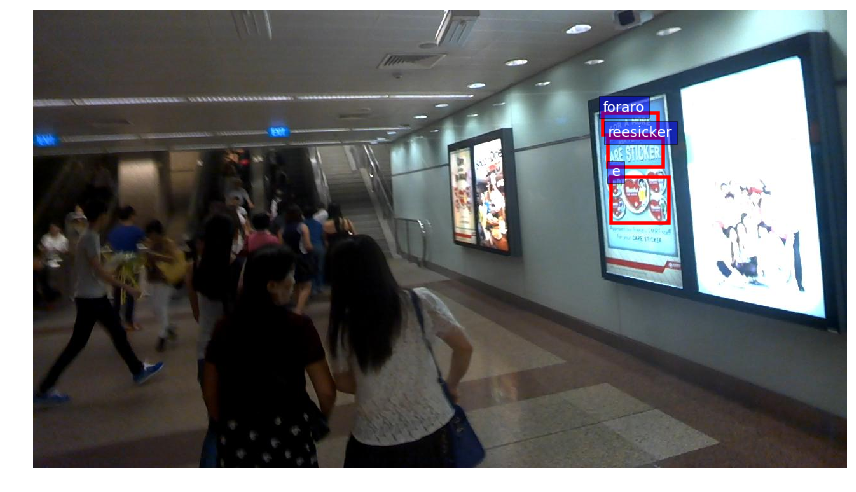

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_102.jpg
[[[  2.68914628e+00  -4.56507301e+00  -3.66955638e+00 ...,  -6.00018787e+00
    -1.09505105e+00  -7.23758554e+00]
  [  2.48351002e+00  -4.72384882e+00  -4.72600269e+00 ...,  -5.61867619e+00
     1.15444148e+00  -7.55510998e+00]
  [  3.93401766e+00  -5.66919136e+00  -4.33837795e+00 ...,  -8.77985191e+00
    -7.07338428e+00  -8.94060421e+00]
  ..., 
  [  3.89127636e+00  -4.35109615e+00  -1.17585337e+00 ...,  -4.03238153e+00
    -2.15875316e+00  -6.74928427e+00]
  [  2.70272255e+00  -3.00520134e+00  -1.00918925e+00 ...,  -4.77187729e+00
    -3.75267673e+00  -6.91436100e+00]
  [  2.25035524e+00  -3.75830150e+00  -1.02074242e+00 ...,  -4.47090244e+00
    -3.69477272e+00  -6.74161673e+00]]

 [[  2.85121703e+00  -4.48336506e+00  -5.64375448e+00 ...,  -8.72519684e+00
    -4.82703781e+00  -1.08880358e+01]
  [  9.04107761e+00  -6.92651367e+00  -7.68427944e+00 ...,  -1.04475708e+01
    -7.43743706e+00  -1.35894

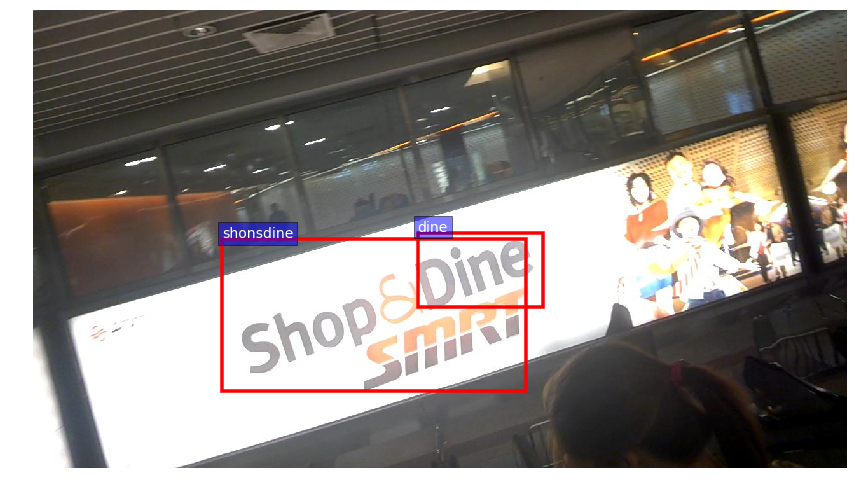

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_103.jpg
[[[  2.6202538   -5.48531389  -0.78419197 ...,  -5.16937828  -5.69307995
    -7.47747564]
  [  1.68596435  -6.08162594  -2.68211889 ...,  -5.17719603  -4.89327526
    -7.08365202]
  [  0.33101457  -3.26570511  -4.15516329 ...,  -5.04272413  -3.28562379
    -4.4253664 ]
  ..., 
  [  2.73759985  -4.67107105  -0.19235158 ...,  -4.0331459   -3.25135255
    -7.65406895]
  [  2.49907923  -4.07934475  -1.24781084 ...,  -4.42164993  -3.12044311
    -6.9913888 ]
  [  2.35501599  -4.19187069  -1.16529739 ...,  -4.31225014  -3.07639241
    -6.94943285]]

 [[  1.38578725  -3.99252105  -1.51778352 ...,  -6.58225775  -7.57032871
    -7.90315962]
  [  3.95335293  -4.91169977  -3.18617702 ...,  -6.75127983  -8.60934162
   -10.05872154]
  [  8.1422472   -5.32368374  -5.07621717 ...,  -8.26894665  -9.06182957
   -10.15447426]
  ..., 
  [ -0.4595173   -2.00945139  -0.29787317 ...,  -4.33618402  -4.52160025
    -4.90293

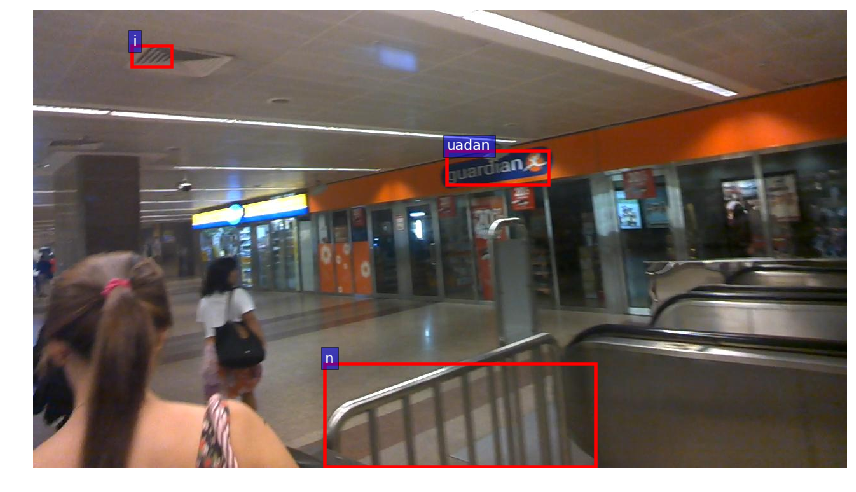

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_104.jpg
[[[  1.91598225  -1.34866095   0.22016636 ...,  -2.80786967  -0.07047997
    -4.17091656]
  [ -0.10165948  -2.67053914  -5.73421955 ...,  -6.49002314  -5.31582069
    -7.22335386]
  [  1.4780798   -2.91924977  -2.70737338 ...,  -4.47228909   0.43589729
    -4.16613865]
  ..., 
  [  0.56871128  -5.45111609  -1.34113133 ...,  -5.01584721  -5.00134993
    -6.13496923]
  [  2.52102518  -4.19583321  -1.05625987 ...,  -4.33880043  -2.97887111
    -7.02979803]
  [  2.59237337  -3.36356091  -1.02323353 ...,  -4.21173906  -2.67595935
    -6.20002317]]

 [[  4.46830654  -1.81834841  -1.69125891 ...,  -5.65343094  -4.56806469
    -9.03604126]
  [  8.61008358  -2.1137929   -6.73766613 ...,  -9.15852356  -9.69952583
   -12.05432701]
  [  4.95427799  -4.13120604  -4.38402319 ...,  -7.19539261  -3.9605794
    -8.94564629]
  ..., 
  [ -0.54853165  -2.60450029  -4.02958012 ...,  -7.37358665  -7.8957181
    -6.6292915

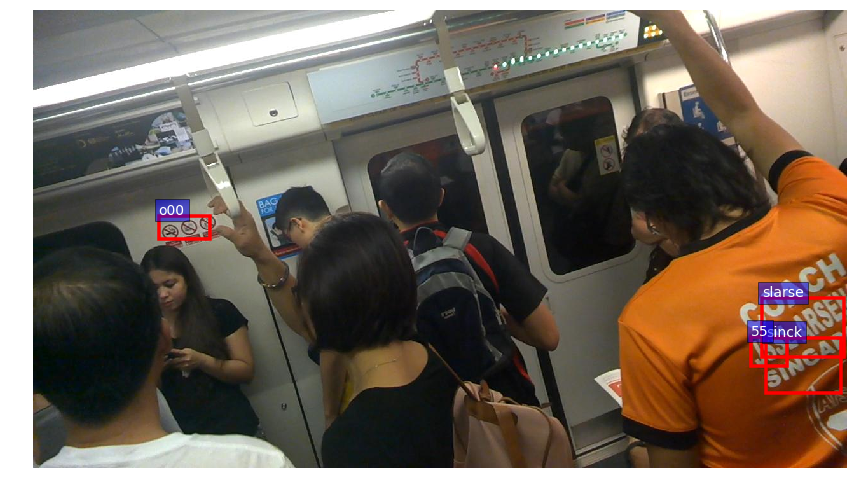

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_105.jpg
[[[  2.39714146e+00  -4.09527922e+00  -3.95940930e-01 ...,  -3.68914628e+00
    -3.29501796e+00  -7.08693075e+00]
  [  1.48912096e+00  -5.09823561e+00  -1.74817550e+00 ...,  -4.13265228e+00
    -3.70293212e+00  -6.44361258e+00]
  [  2.38448286e+00  -4.95829868e+00  -1.60455835e+00 ...,  -4.75025606e+00
    -4.08869648e+00  -7.14602947e+00]
  ..., 
  [  2.36031389e+00  -4.31152344e+00  -1.23015404e+00 ...,  -4.42175865e+00
    -3.25028348e+00  -7.17842150e+00]
  [  2.34262204e+00  -4.47576809e+00  -3.16358495e+00 ...,  -5.63120556e+00
    -4.17765141e+00  -6.65764523e+00]
  [  2.44079947e+00  -3.96038055e+00  -1.07604635e+00 ...,  -4.13859177e+00
    -2.95503736e+00  -6.60038185e+00]]

 [[  3.10293436e+00  -3.73969603e+00  -9.85605896e-01 ...,  -4.93051767e+00
    -6.04396343e+00  -9.41167736e+00]
  [  5.78000128e-01  -3.65300775e+00  -2.46817446e+00 ...,  -5.44995260e+00
    -6.58419561e+00  -6.83794

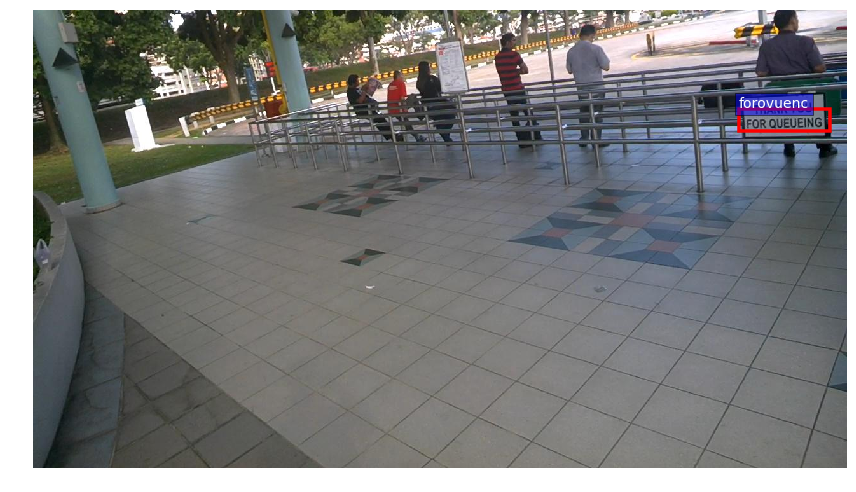

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_106.jpg
[[[  1.65559316  -4.34279871  -4.32407379 ...,  -5.8298707   -3.07099509
    -5.96047068]
  [  6.70435333  -2.04941869   3.52985263 ...,  -1.8278029   -1.82357466
    -7.0784502 ]
  [  3.18573594  -4.76724243  -2.18511462 ...,  -5.65071297  -4.71507788
    -7.85879564]
  ..., 
  [  1.97496891  -3.92757487  -1.39878452 ...,  -4.37428856  -3.47970319
    -6.48369932]
  [  2.39196658  -4.44422817  -1.21259856 ...,  -3.93812108  -2.08776951
    -6.69050789]
  [  2.12748837  -4.74997902  -1.64515746 ...,  -3.73744607  -3.62729287
    -6.15869188]]

 [[  6.62722635  -5.59343815  -5.79837227 ...,  -8.31514359  -8.0132761
   -11.50895786]
  [  2.63861895   2.7481873    2.38112593 ...,  -1.34122515  -0.39204678
    -3.28455114]
  [  2.3637197   -4.34593487  -3.01207709 ...,  -6.74595881  -7.5022769
    -9.36309624]
  ..., 
  [  0.29974234  -2.0822053   -1.54110539 ...,  -5.34152031  -5.92191029
    -6.4137778

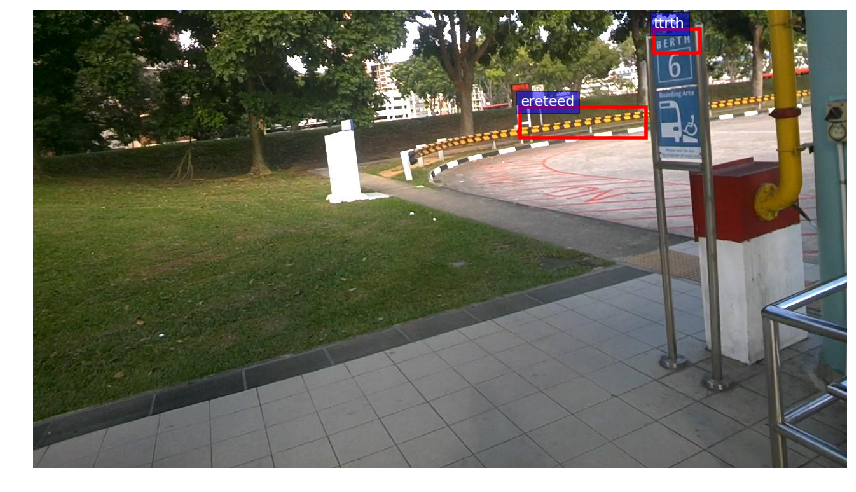

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_107.jpg
[[[  4.10443211e+00  -3.85090089e+00  -7.63470590e-01 ...,  -4.25636387e+00
    -1.40951383e+00  -5.68200016e+00]
  [  4.89392900e+00  -4.32454586e+00  -1.37755430e+00 ...,  -4.87724876e+00
    -2.68341804e+00  -7.80320597e+00]
  [  4.30326509e+00  -4.45078659e+00  -2.70672679e+00 ...,  -5.38084888e+00
    -5.44686079e+00  -7.83846664e+00]
  ..., 
  [  3.66535449e+00  -5.47615623e+00   4.15972322e-01 ...,  -3.64984465e+00
    -3.25271630e+00  -8.73122215e+00]
  [  3.39943504e+00  -4.41015816e+00  -1.85112990e-02 ...,  -2.53950405e+00
    -2.07776237e+00  -7.01554585e+00]
  [  2.68307900e+00  -4.34110641e+00  -1.05355573e+00 ...,  -4.25152302e+00
    -3.66614032e+00  -7.41504526e+00]]

 [[  2.40636730e+00  -3.16100192e+00  -1.44151294e+00 ...,  -5.88892221e+00
    -2.91938448e+00  -4.63877058e+00]
  [  6.75152242e-01  -2.57891059e+00  -7.28568256e-01 ...,  -4.69927025e+00
    -2.44462729e+00  -5.01854

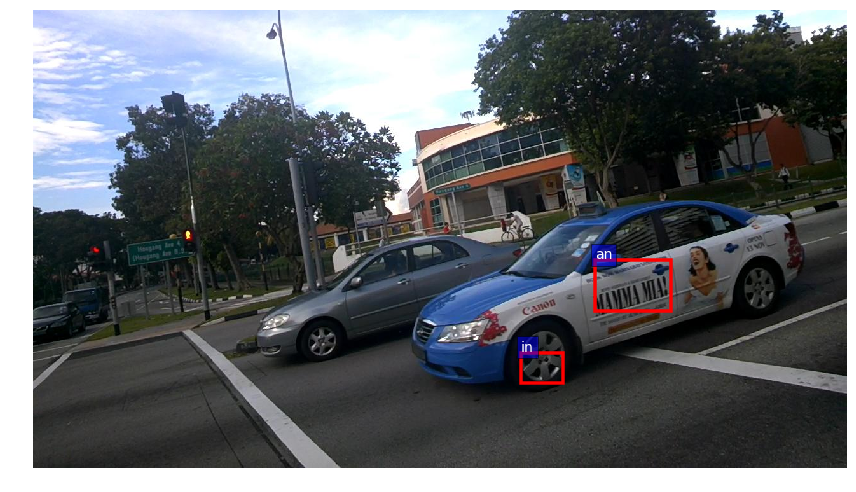

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_108.jpg
[[[  1.84074402  -4.34035587  -1.82703912 ...,  -5.88979864  -5.64375353
    -6.16852188]
  [  3.05257916  -3.99138236  -1.87870574 ...,  -4.48428059  -2.76703572
    -6.96487474]
  [  1.82053685  -4.8680892   -1.8177737  ...,  -5.23452473  -5.09110355
    -6.36665821]
  ..., 
  [  3.29964781  -4.13817787  -0.62556767 ...,  -3.72678733  -2.73723125
    -7.56141329]
  [  3.25304985  -5.42672205  -0.89434671 ...,  -3.61095071  -4.2360301
    -7.22206354]
  [  4.34466791  -5.88170147  -2.75460458 ...,  -6.94239473  -6.07443619
    -9.51231384]]

 [[  3.07545996  -3.87517667  -2.82207274 ...,  -7.34320927  -8.50542259
    -9.18734932]
  [  0.58529586  -1.61106277  -1.2946533  ...,  -4.67325783  -4.29429388
    -5.83713913]
  [  2.16568422  -4.08439922  -2.48566175 ...,  -6.78395033  -7.84345436
    -9.0110054 ]
  ..., 
  [ -0.51845872  -1.73324847   0.38937679 ...,  -3.41658282  -3.42377543
    -5.127006

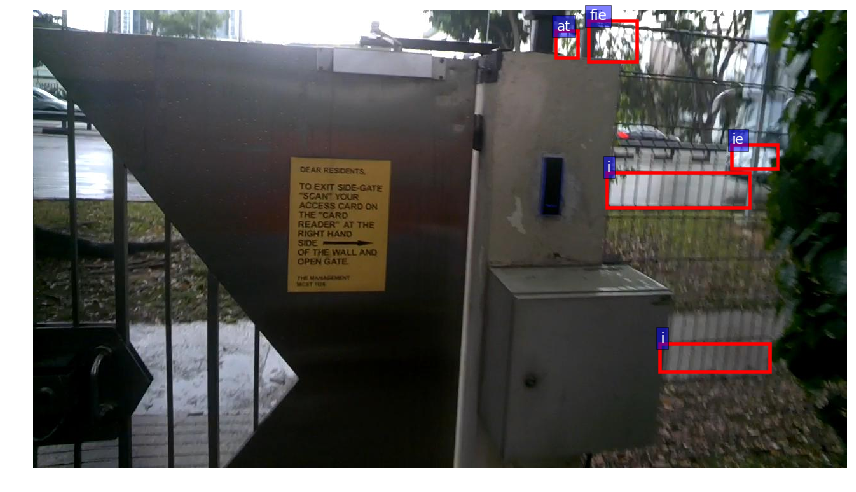

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_109.jpg
[[[  2.18163419  -5.01938629  -2.98417401 ...,  -5.50275993  -4.12902308
    -6.92869139]
  [  0.76769829  -1.38182271  -1.93548226 ...,  -5.32965803  -4.56754875
    -4.40605688]
  [  1.90563774  -3.73261237  -3.46997476 ...,  -6.69196177  -7.82025814
    -4.4477458 ]
  ..., 
  [  4.48660994  -6.06723022  -1.17907524 ...,  -5.07636166  -4.28123379
    -7.89357328]
  [  2.85137343  -3.45390677   1.6920718  ...,  -3.92690086  -3.87889886
    -6.2753253 ]
  [  1.92832637  -3.89745712  -1.1228528  ...,  -4.49570894  -3.4827168
    -6.36482573]]

 [[  3.19740224  -3.60884237  -2.53893447 ...,  -6.54963112  -7.13408661
    -9.19467545]
  [  2.76071644  -0.5243144   -3.34248376 ...,  -7.63339043  -8.54266739
    -7.10413504]
  [  5.92015266  -6.23090887  -3.48969984 ...,  -9.64992714 -11.74361706
   -10.67106438]
  ..., 
  [  3.79963398  -4.64390612  -2.48008561 ...,  -6.4511776   -7.46942425
    -7.582877

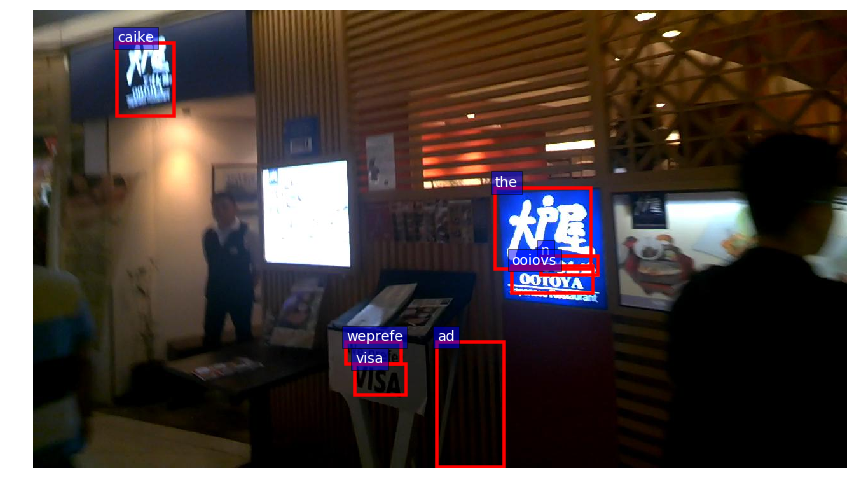

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/data/ICDAR2015_ch4/img_110.jpg
[[[  1.85107613  -4.16106653  -2.2173388  ...,  -5.02771139  -3.95565867
    -6.39074612]
  [  1.28485346  -4.97094345  -3.1871891  ...,  -5.19531918  -4.98818827
    -4.6054678 ]
  [  1.30004048  -7.05204868  -3.12215042 ...,  -4.7645216   -5.26880312
    -7.62060881]
  ..., 
  [  3.149966    -4.07392454  -1.08487475 ...,  -4.7108736   -3.37888074
    -7.11959505]
  [  4.26772976  -3.56439328  -0.48989114 ...,  -4.44606733  -2.57460427
    -6.59606934]
  [  4.15312815  -3.56307387  -0.03083448 ...,  -4.2555337   -2.57565761
    -7.17321682]]

 [[  0.48204243  -2.67943406  -2.50838971 ...,  -6.54002094  -6.65240383
    -7.26720142]
  [  3.50037217  -5.31910896  -4.02933693 ...,  -8.39819336  -9.43197727
    -9.51238728]
  [  4.50144291  -7.37292099  -3.7549355  ...,  -6.71202278  -8.02218151
   -10.33218956]
  ..., 
  [  0.15377401  -1.78134644  -0.95003849 ...,  -4.99297714  -4.21065331
    -4.95959

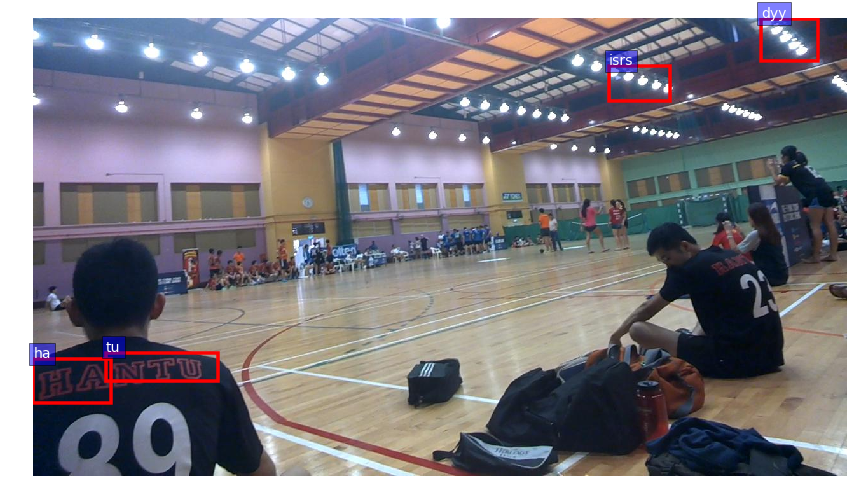

In [18]:
mypath = '/home/xliu/data/ICDAR2015_ch4/'
im_names = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
#im_names = [mypath+ind+'.jpg' for ind in bar_list]
for im_name in im_names[100:110]:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    #print('Demo for data/demo/{}'.format(im_name))
    with torch.no_grad():
        try:
            s,b,t = demo1(net, im_name, CONF_THRESH = 0.8, angle=0)
            plt.show()
        except:
            print("Type Unsupported")
    #plt.show()